# Representational Similarity Analysis
**V.0.1 - Alpha testing, [contributions](#contributions)**

Representational Similarity Analysis (RSA) is a way to compare and contrast different brain states and quantify the space in which they are embedded. RSA is a highly versatile tool: it can be used to compare brain activity to models, compare data across brain imaging techniques, and even to make cross-species comparisions. You can learn about the method RSA by reading the following articles: 
- [Kriegeskorte, N., Mur, M., & Bandettini, P. (2008). Representational similarity analysis - connecting the branches of systems neuroscience. Frontiers in Systems Neuroscience, 2(4), 1–28.](https://doi.org/10.3389/neuro.06.004.2008) 
- [Kriegeskorte, N., & Kievit, R. (2013). Representational geometry: integrating cognition, computation, and the brain. Trends in Cognitive Sciences, 1–12.](https://doi.org/10.1016/j.tics.2013.06.007).
    
## Goal of this script
>1. Work with a new dataset
  - load and explore the new dataset
>2. Learn to compute RSA on a dataset
  - calculate and plot Pearson and Spearman correlations in ROIs
  - order these similarity matrices in a meaningful way
  - be able to interpret a (dis)similarity matrix
>3. Learn to work with Multi Dimensional Scaling as a tool to visualize similarity results

## Table of Contents
[1. Preprocess the data the data](#preprocessing)   
>[1.1 Load the data for one subject](#load_data)  
>[1.2 Visualize the data](#visualize_data)  

[2. Create a similarity matrix](#sim_mat)  
>[2.1 Reorder data into categories](#reorder)  
>[2.2 How to read a similiarity matrix](#read_sim_mat)  

[3. Manifolds and multi-dimensional scaling (MDS)](#mds)   
>[3.1 Plotting RDM in 2d](#plot_2d)
>[3.2 Plotting RDM in 3d](#plot_3d)

Exercises
>[Exercise 1](#ex1)  
>[Exercise 2](#ex2)  
>[Exercise 3](#ex3)  
>[Exercise 4](#ex4)  
>[Exercise 5](#ex5)  
>[Exercise 6](#ex6)  
>[Exercise 7](#ex7)  
>[Exercise 8](#ex8)  
>[Exercise 9](#ex9)  
>[Exercise 10](#ex10) 

[Novel contribution](#novel)  

In [1]:
import numpy as np
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import pandas as pd
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

## 1. Preprocess the data <a id="preprocessing"></a> 

The dataset we will be using for this exercise is from Kriegeskorte et al. (2008), called 'Ninetysix' in the datasets folder. 96 visual stimuli, from the 6 categories listed below, were presented to participants. The image stimuli are stored in the subfolder 'Stimuli'.

The data have 6 categories:  
    1. artificial inanimate (object/scene)
    2. human bodypart 
    3. human face 
    4. natural inanimate (object/scene)
    5. nonhuman bodypart
    6. nonhuman face

**Self-study:** Explore the data

### 1.1 Load the data for one subject<a id="load_data"></a>

The data for these participants are stored as a matlab file (it was 2008 after all...). Python is able to load matlab files using a scipy utility. However, the file formats can be tricky and may require transformations to make compatible with typical Python organization. 

The data from matlab are stored as a dictionary where the variables in the matlab files are keys in the dictionary:

>The ROI names are listed in **roinames**.   
>The category label indices for each condition are listed in **labels**.   
>The label indices correspond to entries in **categoryNames**.  
>The data for each ROI, in the order of roinames, is stored in **roi_data**.  

Each row of roi_data represents a stimulus (as defined in labels) and each column represents a voxel (there will be different numbers of voxels in different ROIs). These data have been preprocessed and each entry is stored in terms of t-values. There is no time information and no baseline signal to be used for reference.

**Self-study:** What do you think these t-values reflect?

The last 4 rows of the dataset have unknown labels (dun dun dunnnnn!). We'll use only the first 92 rows for analysis, for now.

In the analyses that follow we are going to explore the data of subject 'BE'.

In [2]:
# Load the data
# Make sure you edit the following line to reflect the directory where you are accessing the dataset
#dir = '/gpfs/milgram/data/cmhn-s18/datasets/Ninetysix/'  # Yale
dir = '/opt/public_FMRI/NinetySix/'  # Princeton

subj_initials = 'BE'
data = scipy.io.loadmat(dir + subj_initials + '_roi_data.mat')  # Store the mat file as a dictionary
roi_data = data['roi_data']
roi_names = data['roinames']
labels = np.array(data['labels'])
categoryNames = data['categoryNames']
images = scipy.io.loadmat(dir + subj_initials + '_images.mat')['images']  # Store the mat file as a dictionary

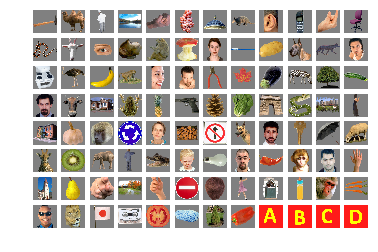

In [3]:
# Load in all of the images for this participant
plt.figure()
for image_counter in range(96):
    plt.subplot(8, 12, image_counter + 1)
    plt.imshow(images[image_counter,0])
    plt.axis('off')

In [4]:
# Load labels and ROIs
categories = [0] * categoryNames.shape[1]
for label_counter in range(categoryNames.shape[1]):
    categories[label_counter] = categoryNames[0, label_counter][0]

rois = [0] * roi_names.shape[1]
for roi_counter in range(roi_names.shape[1]):
    rois[roi_counter] = roi_names[0, roi_counter][0]    
    
# Print the labels
print('Category name:')
print(categories)

# Print the ROIs
print('ROIs:')
print(rois)

Category name:
['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
ROIs:
['lFFA', 'rFFA', 'lLO', 'rLO', 'lPPA', 'rPPA']


**Exercise 1:**<a id="ex1"></a> Check the shape of the data for each ROI. Plot a histogram to show how many images there are in each category.

In [5]:
# Insert code here


In [6]:
# Extract data for a few ROIs (Left/Right FFA and PPA)
lffa_data=np.array(roi_data[0,0])
rffa_data=np.array(roi_data[0,1])
lppa_data=np.array(roi_data[0,4])
rppa_data=np.array(roi_data[0,5])

### 1.2 Visualize the data <a id="visualize_data"></a>

It is always a good idea to plot data as a sanity check before starting analysis. 

We also want to see the corresponding labels. Notice the category order is random.

Text(0,0.5,'Category')

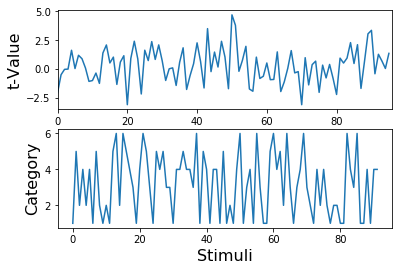

In [7]:
# Data plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(lffa_data[:, 0])  # Plot the activity per stimulus for a single voxel
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

# Label plot
plt.subplot(2,1,2)
plt.plot(labels)
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)

(array([4., 2., 0., 4., 7., 9., 4., 3., 0., 1.]),
 array([-2.09621763, -1.52923164, -0.96224566, -0.39525967,  0.17172632,
         0.73871231,  1.3056983 ,  1.87268429,  2.43967028,  3.00665627,
         3.57364225]),
 <a list of 10 Patch objects>)

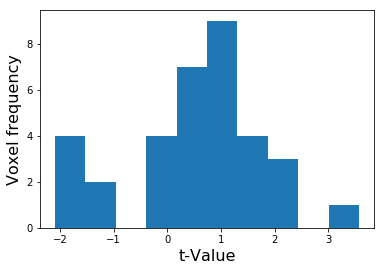

In [8]:
# Display the distribution of t values for different voxels in this ROI.
plt.figure()
plt.ylabel('Voxel frequency', fontsize=16)
plt.xlabel('t-Value', fontsize=16)
plt.hist(lffa_data[0, :])

## 2. Create a similarity matrix <a id="sim_mat"></a>

Let's examine the similarity of the neural representations of each image. We could do that for each of the ROIs that we have just loaded (left and right ffa, and left and right ppa). We can look at the pattern of activity across voxels that each image evokes. We can then correlate those patterns with each other to get a matrix describing how similar they are. We only have category labels for the first 92 images, so we'll start with those.

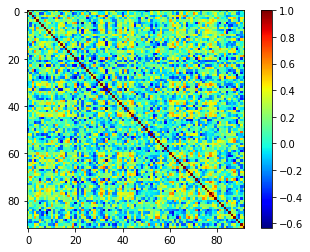

In [9]:
r = np.corrcoef(lffa_data[:92,])  # calculate the Pearson correlation of all possible image pairs of left ffa ROI
plt.figure()  # plot figure of these correlations
plt.imshow(r, cmap='jet')
plt.colorbar()

**Exercise 2:**<a id="ex2"></a> In the plot above you used Pearson correlation to compute similarity. An alternative metric is a Spearman correlation. Explain the difference and redo the analysis above with Spearman correlation.

**A:**

In [10]:
# Insert code here


### 2.1 Reorder data into categories <a id="reorder"></a>

Although the plot above is useful, it is hard to observe any structure because the order of the stimuli is random. To simplify, let's reorganize into label groups.

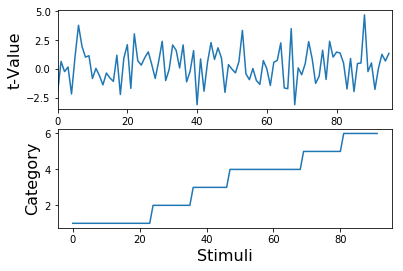

Text(0.5,1,'Pearson R Correlation Matrix: Sorted Trials ')

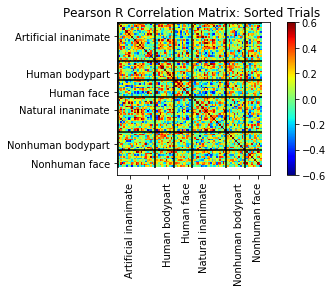

In [11]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
ordered_labels = labels.T.argsort().reshape(96,)
lffa_sorted = lffa_data[ordered_labels, :]

# Plot the new sorted results
plt.figure()
plt.subplot(2,1,1)
plt.plot(lffa_sorted[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(sorted(labels))
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()


r = np.corrcoef(lffa_sorted[:92,])
plt.figure()
plt.imshow(r, cmap='jet')
plt.colorbar()

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
#edges = np.cumsum(binsize)[:-1]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]

plt.xticks(list(np.array(edges)+8), ('Artificial inanimate', 'Human bodypart', 'Human face', 'Natural inanimate', 'Nonhuman bodypart', 'Nonhuman face'),
         rotation = 90)
plt.yticks(list(np.array(edges)+8), ('Artificial inanimate', 'Human bodypart', 'Human face', 'Natural inanimate', 'Nonhuman bodypart', 'Nonhuman face'))
plt.vlines(edges,0,92)
plt.hlines(edges,0,92)
plt.tight_layout()
plt.clim(-0.6, 0.6)
plt.title('Pearson R Correlation Matrix: Sorted Trials ')

**Exercise 3:**<a id="ex3"></a> This new organization is helpful but could be improved (based on our knowledge of the brain). Order the datapoints so that the categories are as follows: human body part, human face, non-human body part, non-human face, natural inanimate and artificial inanimate. This will make for a nicer looking correlation matrix and will help you see any structure within and between categories. Recompute the Pearson correlation similarity matrix.

In [12]:
# Insert code here


### 2.2 How to read a similarity matrix <a id="read_sim_mat"></a>

It is important to be able to read a similarity matrix at a glance. There are couple features to look out for and we will highlight these with some toy data.

Imagine a scenario where we have 12 trial types (e.g., images) grouped into 4 conditions (e.g., faces, objects, body parts, and scenes). We are going to simulate some data that has similar structure within category but different structure between categories.

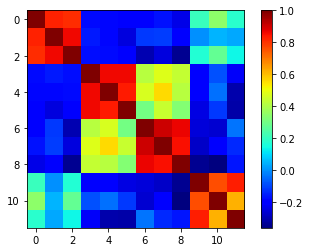

In [13]:
trial_types = 12
trial_conditions = 4
repetitions_per_trial = 24
trial_noise = 0.5
trials_per_condition = int(trial_types / trial_conditions)

# The template per category
category_templates = np.random.randn(trial_conditions, repetitions_per_trial)

# Create the trial activity
trials = np.zeros((trial_types, repetitions_per_trial))
for condition_counter in range(trial_conditions):
    condition_trials = np.random.randn(trials_per_condition, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_condition):
        trials[(trials_per_condition * condition_counter) + trial_counter, :] = category_templates[condition_counter, :] + condition_trials[trial_counter, :]

# Create the correlation matrix    
sim_r1 = np.corrcoef(trials)
plt.figure()
plt.imshow(sim_r1, interpolation='none', cmap='jet')
plt.colorbar()

In the above plot you should see some clear blocking structure along the diagonal: items within a category are more similar to one another than they are to items in different categories.

Below we create a plot where there is off-diagonal structure. High similarity in off-diagonal parts of a similarity matrix means that elements that are far apart in the ordering have similar structure. In this toy simulation we create an example where the first and third categories are similar to one another (i.e., faces and body parts).

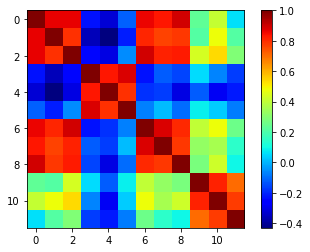

In [14]:
# Overwrite the template for the 3rd category with the template for 1st category
category_templates[2, :] = category_templates[0, :]

# Create the trial activity
trials = np.zeros((trial_types, repetitions_per_trial))
for condition_counter in range(trial_conditions):
    condition_trials = np.random.randn(trials_per_condition, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_condition):
        trials[(trials_per_condition * condition_counter) + trial_counter, :] = category_templates[condition_counter, :] + condition_trials[trial_counter, :]

# Create the correlation matrix    
sim_r2 = np.corrcoef(trials)
plt.figure()
plt.imshow(sim_r2, interpolation='none', cmap='jet')
plt.colorbar()

**Exercise 4:**<a id="ex4"></a> Now use your new knowledge about reading a similarity matrix to interpret the matrix you created for the real data.

**A:**

**Exercise 5:**<a id="ex5"></a> The previous analyses framed everything in terms of similarity between the items. However people sometimes prefer to consider this type of data in terms of dissimilarity. This close cousin of the similarity matrix is called the representational dissimilarity matrix (RDM). The dissimilarity matrix is computed simply as 1 - correlation. Plot the RDM for the right FFA ROI using the new order as you created above.

In [15]:
# Insert code here


**Exercise 6:** For RDM plots based on correlation values, what does an RDM value greater than 1 correspond to in terms of a correlation?

**A:**

## 3. Manifolds and multi-dimensional scaling (MDS) <a id="mds"></a>

The correlation matrix for the 92 images describes how similar each item is to each other item. This means that if two items have a high positive correlation then they can be thought of as eliciting a very similar activation pattern across voxels. We can reframe this to be thought of as a distance in a high-dimensional space. From this perspective, items that are similar to one another will be grouped close together and far away from points that they are dissimilar to. 

Multi-Dimensional Scaling (MDS) allows us to visualize precisely the similarity of our data in a different way then plotting the matrices as we did above. This [method](https://homepages.uni-tuebingen.de/florian.wickelmaier/pubs/Wickelmaier2003SQRU.pdf) is [built-in in scikit-learn](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling).

In [16]:
#Create a 2-D MDS
r = np.corrcoef(lffa_data[:92,])
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(1 - r)  # Use the dissimilarity matrix

**Exercise 7:**<a id="ex7"></a> How does changing the order of the data (e.g., shuffling the rows/columns) in your RDM affect the distance between points calculated by MDS?

**A:**

### 3.1 Plot the 2D structure of the RDM <a id="plot_2d"></a>

We'll plot the 92 images on a "map" signifying how close or far apart images are to each other. We use different colors for the 6 categories of images.

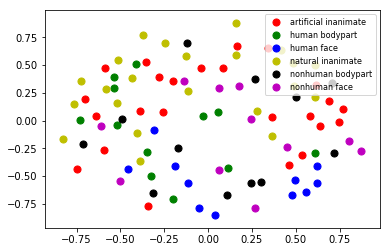

In [17]:
coords = results.embedding_

plt.figure()
color_list = ['r', 'g', 'b', 'y', 'k', 'm']
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:,0]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1], marker = 'o', s = 50, c=color_list[int(label_counter - 1)]
        )

plt.legend(categories, prop={'size': 8})

**Self-study**: On the MDS plot you are currently plotting each item is a point. You could instead load in each image and plot that image on the MDS plot directly to get a feel for what images are being grouped.

### 3.2 Plot the 3D structure of the RDM <a id="plot_3d"></a>

MDS is just trying to find a k-dimensional embedding that minimizes the stress (something akin to the goodness of fit). This means we can actually plot it in arbitrarily high dimensions to try and capture the data structure. Below we make a 3D plot.

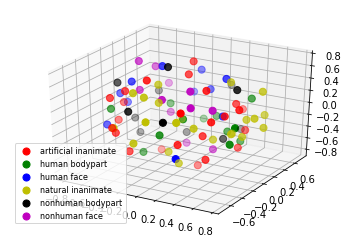

In [18]:
# Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(1 - r)

coords = results.embedding_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:,0]
    ax.scatter(coords[label_idxs, 0], coords[label_idxs, 1], coords[label_idxs, 2], marker = 'o', s = 50, c=color_list[int(label_counter - 1)]
        )
plt.legend(categories, prop={'size': 8})

There are tools available to us to evaluate what is the appropriate dimensionality for visualization of our data (i.e. what dimensionality has sufficiently low stress). We can look at the stress of the MDS with different numbers of components (i.e. different dimensionality) and determine what dimensionality of the data is appropriate.

Let's make a toy problem to start off with in order to get a handle on what this should look like. We are going to make points that lie on a line in 3 dimensional space. Because a line has only one dimension of information (along its length) the data ought to be able to be reduced in dimensionality to a single dimension. We will run MDS on this data to see if that is the case.

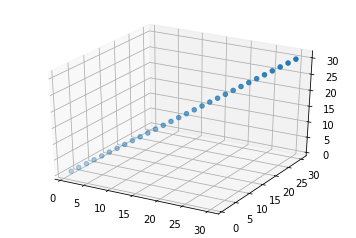

In [19]:
coords = np.linspace(1, 30, 30)
coords = np.vstack((coords, coords, coords)).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])

Text(0.5,0,'Dimensionality')

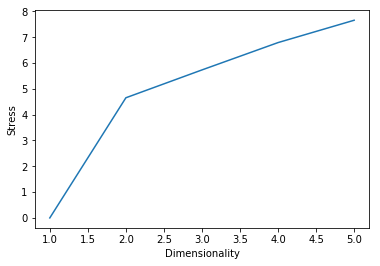

In [20]:
# Calculate the euclidean distance of every point from every other point
dist = sp_distance.squareform(sp_distance.pdist(coords))

# Iterate through different numbers of components
stress = [0] * 5
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    
    # Pull out the stress of the MDS fit
    stress[components - 1] = mds.fit(dist).stress_

# Plot the stress
plt.figure(); 
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')

**Exercise 8:**<a id="ex8"></a> It is not typical for data to be able to be described accurately in low dimensionality: stress generally decreases with the number of components. Perform a similar analysis below to estimate the appropriate dimensionality to visualize the RDM of the left FFA data from this participant. What is the appropriate lower dimensional representation of the data? Note: Make sure you don't calculate the stress metric from the MDS embedding, calculate the MDS fit from the RDM.

**A:**

In [21]:
# Insert code here


**Exercise 9:**<a id="ex9"></a> Compute RDMs and create MDS plots for the left PPA and right PPA using the reordering you created above.

In [22]:
# Insert code here


**Exercise 10:** <a id="ex10"></a>The last four rows in the dataset for subject BE have unmarked labels. One of them is a human face. Using the techniques outlined here and your knowledge of the brain regions -- LOC, PPA, and FFA, analyze the data to make a best guess of which one of the 4 data points is a human face. Show your work and reasoning that led you to this conclusion. Even if you aren't right, it is more about your process. Hint: It would really help you to be able to visualize these 4 points amongst the points you already have.

In [23]:
# Insert code here


**Novel contribution:**<a id="novel"></a>  be creative and make one new discovery by adding an analysis, visualization, or optimization.

## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  
T. Meissner minor edits  
Francisco Pereira created all the matlab files and images used here. This notebook is based on a matlab exercise that he had created.